# Try to run the code with 8GB Ram or Colab for avoiding runtime error

## Analysis
- In this notebook, the rainfall of a month is predicted based on the month of previous years.

In [13]:
conda install python-graphviz

Solving environment: done

## Package Plan ##

  environment location: /home/user/anaconda3

  added / updated specs:
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.9.0                |           py37_0         2.9 MB
    graphviz-2.40.1            |       h21bd128_2         6.5 MB
    python-graphviz-0.14.2     |             py_0          20 KB
    ------------------------------------------------------------
                                           Total:         9.4 MB

The following NEW packages will be INSTALLED:

  graphviz           pkgs/main/linux-64::graphviz-2.40.1-h21bd128_2
  python-graphviz    pkgs/main/noarch::python-graphviz-0.14.2-py_0

The following packages will be UPDATED:

  conda              conda-forge::conda-4.8.4-py37hc8dfbb8~ --> pkgs/main::conda-4.9.0-py37_0



conda-4.9.0          | 2.9 MB    | ################################

### Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection
import plotly.figure_factory as ff
from IPython.display import HTML, display
from IPython.core import display as ICD
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import Artificial_Neural_Networks as ANN
import ARIMA

import math
from itertools import groupby
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from importlib import reload
import itertools

### Useful functions

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

def calculate_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return round(mse, 3), round(mae, 3), round(mape, 3), round(rmse, 3)

### Dataset

In [3]:
PATH = 'Dataset/rainfall_data_1901_to_2002.xlsx'
data = pd.read_excel(PATH)

### Preprocess data

In [4]:
data = data.drop(columns='vlookup')
data = data[data['Year'].notnull()]
data['Year'] = data.Year.astype('int')
data.index = range(len(data))

m_data = data[data['State'] == 'Maharashtra']
m_data = m_data.drop(columns='State')

districts = m_data.District.unique()
years = list(range(1901, 2003))
months = data.columns[3:]
year_month = [str(year) + '_' + month for year in years for month in months]
dates = pd.date_range(start='1901-01', freq='MS', periods=len(years)*12)

maharashtra_data = pd.DataFrame({'Year_Month': year_month})
maharashtra_data['Date'] = dates
maharashtra_data[['Year', 'Month']] = maharashtra_data['Year_Month'].str.split('_', n=1, expand=True)
maharashtra_data = maharashtra_data.drop(columns=['Year_Month'])

for district in districts:
    df = m_data[m_data.District == district].drop(columns=['District', 'Year'])
    df = df.to_numpy().reshape((len(years) * len(months), 1))[:,0]
    maharashtra_data[district] = df

maharashtra_data.head()

,Date,Year,Month,Ahmadnagar,Akola,Amravati,Aurangabad,Bhandara,Bid,Buldana,...,Nashik,Osmanabad,Parbhani,Pune,Sangli,Satara,Solapur,Wardha,Washim,Yavatmal
0,1901-01-01,1901,Jan,2.510,34.202,35.651,10.922,23.397,16.647,31.455,...,5.063,15.500,33.207,0.922,0.138,0.197,4.496,45.050,32.485,22.031
1,1901-02-01,1901,Feb,11.489,1.099,6.822,4.362,63.844,1.916,0.823,...,1.609,2.784,4.997,7.195,0.537,0.525,3.667,28.220,3.607,16.198
2,1901-03-01,1901,Mar,11.325,30.002,36.103,25.161,33.563,27.287,28.448,...,11.196,11.333,31.625,5.105,13.090,9.566,10.330,26.398,26.557,29.318
3,1901-04-01,1901,Apr,33.931,10.248,10.636,12.714,61.560,33.211,13.902,...,7.838,34.814,41.941,35.949,50.077,30.110,59.854,29.228,18.127,30.521
4,1901-05-01,1901,May,30.401,2.891,4.173,34.244,13.665,59.027,9.397,...,7.475,52.792,31.794,36.650,78.994,65.226,50.892,8.619,6.700,13.193


In [5]:
m_data = maharashtra_data.copy()

In [6]:
districts_of_interest = ['Kolhapur', 'Latur']
months_of_interest = ['Jun', 'Jul', 'Aug', 'Sep']

In [7]:
rainfall_season_data = m_data[m_data.Month.isin(months_of_interest)]
rainfall_season_data = rainfall_season_data[['Date', 'Year', 'Month'] + districts_of_interest]

In [8]:
rainfall_season_data.head()

,Date,Year,Month,Kolhapur,Latur
5,1901-06-01,1901,Jun,554.047,188.878
6,1901-07-01,1901,Jul,496.636,175.092
7,1901-08-01,1901,Aug,507.657,138.084
8,1901-09-01,1901,Sep,221.539,102.949
17,1902-06-01,1902,Jun,631.349,46.720


### Parameters

In [9]:
future_steps = 10
STORAGE_FOLDER = 'State_predictions/'
if not os.path.exists(STORAGE_FOLDER):
    os.makedirs(STORAGE_FOLDER)

parameters_WNN = [[3,6,8,10,12], [4,5,6], [1], [300], [20], [future_steps]]
#parameters_WNN = [[12], [4], [1], [50], [20], [future_steps]]


# seasonal_period, hidden_nodes, epochs, batch_size, future_steps
parameters_WAANN = [[12], [3,4,5,6], [300], [20], [future_steps]]
#parameters_WAANN = [[12], [3], [50], [20], [future_steps]]



### Run, Compare and Save output

WNN - Number of combinations: 15
1 -> [592.5699741600752, 609.4381802943348, 600.004830613911, 593.4930113108753, 593.4144988878965, 592.3420604844689, 592.0263166607022, 591.9210157778263, 591.8398562738298, 591.814920770645]
2 -> [588.8844167886077, 654.9010026454924, 577.9772518100738, 618.2941486632227, 583.1635982352196, 605.1181440737843, 588.2063140443563, 599.5977624950408, 591.2451101108193, 597.046823460102]
3 -> [581.8109663060902, 619.4987293510436, 609.6972236427068, 596.2579933168887, 600.0743429614305, 597.1444478080272, 596.4499596322775, 596.5505487109422, 596.1566101139186, 596.1288687048553]
4 -> [598.8892977315187, 586.1983177969157, 589.475933512777, 575.191331393212, 611.758717397511, 626.4904115009307, 599.8364233195781, 592.0403197192846, 587.774283951491, 587.8887966763078]
5 -> [600.6562772523164, 621.015983248651, 631.84069165349, 616.0826712979674, 594.4632723870277, 613.9758065745234, 605.5402476128339, 602.8715134726166, 604.7095935895442, 606.588332870900

3 -> [657.3973239425421, 705.6988288084269, 694.7804842159749, 662.7836439362765, 671.6172679111958, 689.4111410281658, 637.9519891977906, 698.5862480030061, 724.0461613736153, 642.3357431388497]
4
[649.4478177551031, 644.6658097521066, 642.6292939183712, 679.674709204197, 690.1727610371114, 617.9438499740362, 594.5444380161762, 708.8741534561516, 571.6099413398504, 697.9106801525355]
=== Best parameters of WAANN ===

Input nodes(s): 12.0
Hidden nodes: 3.0
Output nodes: 12.0
Number of epochs: 300.0
Batch size: 20.0
Number of future steps forecasted: 10.0
Mean Squared Error(MSE): 57274.812
Mean Absolute Error(MAE): 174.254
Root Mean Squared Error(RMSE): 239.322



[241.012, 239.322]
Overall Best method on this data is WAANN
=== Best parameters of WAANN ===

Input nodes(s): 12.0
Hidden nodes: 3.0
Output nodes: 12.0
Number of epochs: 300.0
Batch size: 20.0
Number of future steps forecasted: 10.0
Mean Squared Error(MSE): 57274.812
Mean Absolute Error(MAE): 174.254
Root Mean Squared Error(R

13 -> [351.2500877606868, 170.00428329479695, 120.33288387274742, 194.86005359184742, 278.0568389952779, 239.9707500992417, 162.82114451748132, 212.5587309102416, 252.28523156183954, 245.3540406197905]
14 -> [324.2639104156494, 217.4502433243394, 122.64270747444033, 175.66459247285127, 272.8548940889239, 266.3067295977473, 191.75794325858354, 182.8683450373411, 219.2572924783826, 248.23003999292848]
15
[319.07113028764724, 182.9737678448558, 130.8464585327506, 187.6884473927617, 258.65494751161333, 244.93211260974405, 194.27395348083974, 205.9315933290124, 230.14109354168176, 236.9162046870589]
=== Best parameters of WNN ===

Input nodes(p): 3.0
Hidden nodes: 5.0
Output nodes: 1.0
Number of epochs: 300.0
Batch size: 20.0
Number of future steps forecasted: 10.0
Mean Squared Error(MSE): 11005.301
Mean Absolute Error(MAE): 90.393
Root Mean Squared Error(RMSE): 104.906



WAANN - Number of combinations: 4
1 -> [226.8200452890992, 161.11728965342044, 253.43794618368145, 186.3238286100626, 1

6 -> [137.95230473145844, 167.75038992446662, 158.6367179413438, 160.3268458416462, 151.20179524552822, 148.6085952962637, 155.06033910286428, 155.86569204485417, 156.54631923359634, 156.6082870194912]
7 -> [153.7686733724475, 179.57963462531566, 159.99971071803571, 128.3243738756776, 134.92999235153198, 140.90771508127452, 164.5004438260794, 156.89881040221454, 147.12568809342386, 141.11170481455326]
8 -> [131.54523251661658, 157.77484068572522, 162.54292730018497, 149.12796400901675, 139.18406592756511, 143.20551886215807, 146.45126821902394, 156.03196378320456, 154.68662717220187, 151.15165384212136]
9 -> [129.98225359269978, 159.46003434181213, 161.22212143355608, 154.6949416370988, 139.3127074689269, 143.44760412150623, 146.7369802746475, 154.89775487798454, 156.10705736109614, 151.96147569924594]
10 -> [114.87218425804377, 158.651626031518, 170.8900530306995, 143.90353882277012, 127.38951897251607, 141.6352614890337, 147.39919623541832, 153.84219536721707, 155.79241588431597, 139

[57.339, 63.261]
Overall Best method on this data is WNN
=== Best parameters of WNN ===

Input nodes(p): 8.0
Hidden nodes: 4.0
Output nodes: 1.0
Number of epochs: 300.0
Batch size: 20.0
Number of future steps forecasted: 10.0
Mean Squared Error(MSE): 3287.726
Mean Absolute Error(MAE): 45.858
Root Mean Squared Error(RMSE): 57.339



WNN - Number of combinations: 15
1 -> [267.35820833742616, 243.93304267960787, 224.79377014121414, 203.48931717136503, 211.14089712673425, 217.84381144279243, 225.63229071328044, 223.1553453988731, 220.81586367991568, 217.9745527421236]
2 -> [269.94670941990614, 246.20173175093532, 226.18946847242117, 205.03737119197845, 212.95944996434451, 220.2805088492334, 227.659038459152, 225.01628059613705, 222.3479338468015, 219.7700682218671]
3 -> [269.6785781269073, 244.484369097054, 224.02057115095855, 202.83608908629418, 211.7761295760274, 219.43375714451074, 226.85993164151907, 223.68026104342937, 220.82465909290315, 218.2199901522398]
4 -> [214.9738571447134, 26

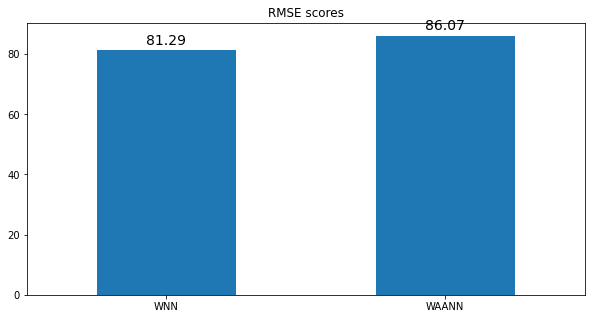

In [10]:
for district in districts_of_interest:
    temp_data = rainfall_season_data[['Date', 'Year', 'Month', district]]
    for month in months_of_interest:
        df = temp_data[temp_data.Month == month]
        df.index = range(len(df))
        df = df[['Date', district]]
        dates = df.Date
        
        rainfall_data = pd.DataFrame({'Precipitation': df[district][:-1*future_steps]})
        rainfall_data.index = dates[:-1*future_steps]
        
        test_rainfall_data = pd.DataFrame({'Precipitation': df[district][-1*future_steps:]})
        test_rainfall_data.index = dates[-1*future_steps:]
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(rainfall_data)

        output_folder = STORAGE_FOLDER + district + '_' + month + '/'
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        ANN = reload(ANN)
        RMSE_info = ANN.compare_ANN_methods(rainfall_data, test_rainfall_data, scaler, 
                        parameters_WNN,parameters_WNN, parameters_WAANN, parameters_LSTM, future_steps, output_folder)

        ANN = reload(ANN)
        ANN.save_RMSE_info(output_folder, RMSE_info)

In [ ]:
Since we used 300 epochs but by default we need to use 1000epochs for Wavelet Neural Network for better accuracy, due to lack of Memory 

State_predictions/Kolhapur_Jun/
(0, 0, 0)
1447.50889480904
1392.8712403941047
1140.1872082836812
1110.6166054364182
1325.1389829924722
1299.7849693330024
1117.444755761553
1112.129407745656
(0, 0, 1)
1391.7596185962182
1363.2646271124092
1142.161042089292
1112.5136422254877
1324.7382151851014
1301.1127636763463
1118.7428194899403
1113.879220452003
(0, 1, 0)
1292.4687115227955
1294.4629149382379
1178.8490724904273
1154.2353423415025
1294.4646975718508
1293.508289121258
1165.47653323321
1156.0192361217412
(0, 1, 1)
1234.098504417735
1236.0914327188148
1134.5483532490596
1103.4853748187281
1236.0899638882618
1237.329509436079
1110.0059997784936
1104.9803529151588
(1, 0, 0)
1305.2533320368864
1306.7338948631375
1142.1234781874466
1112.4818991307816
1306.7774744709973
1309.1416127942264
1118.4771139841946
1113.805812515327
(1, 0, 1)
1251.6910046204835
1253.6750753142949
1141.6523181521343
1114.4795878063842
1253.6731392327479
1256.0707476768243
1121.4379820699346
1116.093588306132
(1, 1, 0)

State_predictions/Latur_Aug/
(0, 0, 0)
1197.3598660797195
1170.7387988971034
992.8242245613922
952.9423018103197
1138.5012099214828
1108.3046410702427
967.5175450440288
954.3093176001119
(0, 0, 1)
1157.692789561411
1143.5691851757324
993.189639422482
954.7776471581346
1130.5345758983383
1107.9288239089121
969.4750796605952
956.2351216923137
(0, 1, 0)
1109.9448705127836
1111.917404904938
1024.2002357743681
991.5917771263248
1111.9191146095598
1113.7340520200398
1008.1813152349707
993.5491125708207
(0, 1, 1)
1057.897898101518
1059.1892037395687
987.7082735225696
947.3521977272559
1059.1284558143666
1060.819861455307
963.1647768008369
947.839074589982
(1, 0, 0)
1114.7328595856898
1116.1194673838727
993.3555799117878
954.7619548185073
1116.00436902629
1106.764305393107
969.4722042420251
956.2245619591846
(1, 0, 1)
1072.6493170147635
1073.9408862882995
995.0414110564969
956.269040537314
1073.8800920710203
1076.6945683190197
971.1937731569486
957.0491100816646
(1, 1, 0)
1091.2911077221092
10

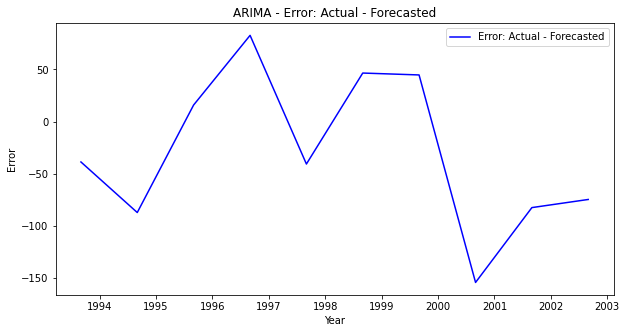

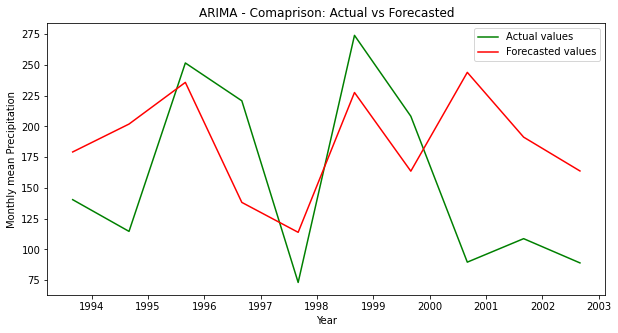

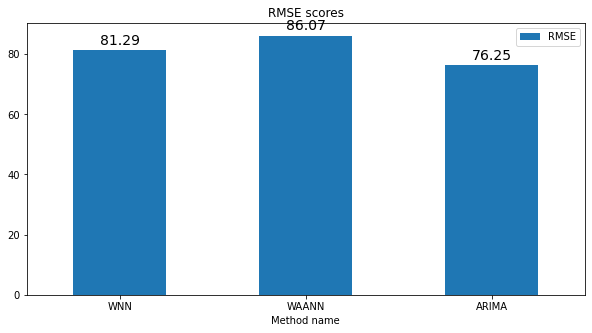

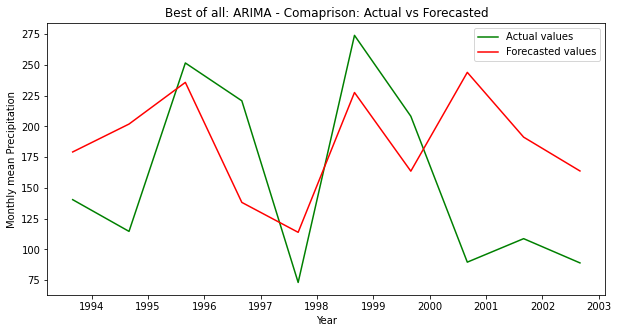

In [11]:
for district in districts_of_interest:
    temp_data = rainfall_season_data[['Date', 'Year', 'Month', district]]
    for month in months_of_interest:
        df = temp_data[temp_data.Month == month]
        df.index = range(len(df))
        df = df[['Date', district]]
        dates = df.Date
        
        rainfall_data = pd.DataFrame({'Precipitation': df[district][:-1*future_steps]})
        rainfall_data.index = dates[:-1*future_steps]
        
        test_rainfall_data = pd.DataFrame({'Precipitation': df[district][-1*future_steps:]})
        test_rainfall_data.index = dates[-1*future_steps:]
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(rainfall_data)

        output_folder = STORAGE_FOLDER + district + '_' + month + '/'
        print(output_folder)
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        ARIMA = reload(ARIMA)
        forecasted_values = ARIMA.ARIMA(rainfall_data, output_folder, future_steps)

        errors = test_rainfall_data.Precipitation - forecasted_values
        ARIMA_actual_forecasted = pd.DataFrame({'Actual': test_rainfall_data.Precipitation, 
                                               'Forecasted': forecasted_values,
                                               'Errors': errors})
        ARIMA_actual_forecasted.to_csv(output_folder + '/' + 'ARIMA_actual_and_forecasted.csv')

        plt.figure(figsize=(10,5))
        plt.plot(ARIMA_actual_forecasted.drop(columns=['Actual', 'Forecasted']), color='blue', label='Error: Actual - Forecasted')
        plt.xlabel('Year')
        plt.ylabel('Error')
        plt.legend(loc='best')
        plt.title('ARIMA - Error: Actual - Forecasted')
        plt.savefig(output_folder + 'ARIMA_error_plot'  + '.png')

        y_true = test_rainfall_data.ix[:int(future_steps)]
        plt.figure(figsize=(10,5))
        plt.plot(y_true, color='green', label='Actual values')
        plt.plot(forecasted_values, color='red', label='Forecasted values')
        plt.xlabel('Year')
        plt.ylabel('Monthly mean Precipitation')
        plt.legend(loc='best')
        plt.title('ARIMA - Comaprison: Actual vs Forecasted')
        plt.savefig(output_folder + 'ARIMA_best_forecast'  + '.png')

        mse, mae, mape, rmse = calculate_performance(y_true, forecasted_values)
        RMSE_score = pd.read_csv(output_folder + 'RMSE_score.csv')
        best_method = RMSE_score.iloc[RMSE_score.RMSE.argmin]['Unnamed: 0']
        RMSE_score = RMSE_score.append({'Unnamed: 0': 'ARIMA', 'RMSE': str(rmse)}, ignore_index=True)
        RMSE_score.RMSE = RMSE_score.RMSE.astype('float')

        current_best_method = RMSE_score.iloc[RMSE_score.RMSE.argmin]['Unnamed: 0']

        RMSE_score = RMSE_score.set_index('Unnamed: 0')
        RMSE_score.to_csv(output_folder + 'RMSE_score.csv')

        axis = RMSE_score.plot(kind='bar', figsize=(10,5), rot=0, title='RMSE scores')
        axis.set_xlabel('Method name')
        for p in axis.patches:
            axis.annotate(np.round(p.get_height(),decimals=2), 
                        (p.get_x()+p.get_width()/2., p.get_height()), 
                        ha='center', va='center', xytext=(0, 10), 
                        textcoords='offset points', fontsize=14, color='black')

        fig = axis.get_figure()
        fig.savefig(output_folder + 'RMSE.png')

        if current_best_method == 'ARIMA':
            y_true = test_rainfall_data.ix[:int(future_steps)]
            plt.figure(figsize=(10,5))
            plt.plot(y_true, color='green', label='Actual values')
            plt.plot(forecasted_values, color='red', label='Forecasted values')
            plt.xlabel('Year')
            plt.ylabel('Monthly mean Precipitation')
            plt.legend(loc='best')
            plt.title('Best of all: ARIMA - Comaprison: Actual vs Forecasted')
            plt.savefig(output_folder + 'BEST_FORECAST_ARIMA'  + '.png')
            os.remove(output_folder + 'BEST_FORECAST_' + best_method + '.png')